## L1 regularization on linear scale

For the linear scale it should be enough to just specify the priors in the parameters table of the petab problem. For the `log10` scale this should also suffice, but we need to think whether we want to have priors on the linear scale or on the original parameter scale (`log10`).

For the `log10_shift` and the `logicle` scale this is a little bit more involved, since we cannot specify those scales in the parameters table.

In [101]:
import libsbml
import importlib
import os
import sys
import shutil
import pandas as pd



import amici
import matplotlib.pyplot as plt
import numpy as np 
import petab 
from petab.C import *

import pypesto
import pypesto.optimize as optimize
import pypesto.petab
import pypesto.visualize as visualize
import pypesto.objective

In [102]:
# create parameter table with priors

param_scale = 'lin'

parameter_df = pd.DataFrame(
    data={
        PARAMETER_ID: ['k1', 'k2', 'k3', 'sd_observed_B'],
        PARAMETER_SCALE: [param_scale] * 4,
        LOWER_BOUND: [0] * 4,
        UPPER_BOUND: [1000] * 4,
        NOMINAL_VALUE: [0.2, 0.1, 0.0, 0.15],
        ESTIMATE: [1, 1, 1, 0],
        'initializationPriorType': ['laplace', 'laplace', 'laplace', None],
        'initializationPriorParameters': ['0; 1', '0; 1', '0; 1', None],
        'objectivePriorType': ['laplace', 'laplace', 'laplace', None],
        'objectivePriorParameters': ['0; 1', '0; 1', '0; 1', None]

    }
).set_index(PARAMETER_ID)

petab.write_parameter_df(parameter_df, "petab/"+param_scale+"/parameters.tsv")

Maybe modifications by hand are needed afterwards to get the `PriorParameters` of the form `location;scale`.

In [ ]:
model_name= "Spoegler_conversionReaction"


# the yaml file includes all important links to other files
yaml_config ="petab/"+param_scale+"/"+model_name+".yaml"
# create a petab problem
petab_problem = petab.Problem.from_yaml(yaml_config)

# or create from folder (did not work)
# petab_problem = petab.Problem.from_folder("petab/"+param_scale)

# import to amici
importer = pypesto.petab.PetabImporter(petab_problem)
importer.compile_model()

model = importer.create_model()

In [74]:
# initialize solver and options
solver = importer.create_solver(model)

# enable sensitivities
solver.setSensitivityOrder(amici.SensitivityOrder_first)       
solver.setSensitivityMethod(amici.SensitivityMethod_forward)  
model.requireSensitivitiesForAllParameters()     

In [75]:
# objective function
obj = importer.create_objective()

Using existing amici model in folder /home/vinc777/python_projects/moses/spoegler_model_reduction/l1_regularization/amici_models/Sp_gler_ConversionReaction.


In [130]:
print('optimal x = ', petab_problem.x_nominal)
print('optimal lh value', problem.objective(petab_problem.x_nominal[0:3]))

optimal x =  [0.2, 0.1, 0.0, 0.15]
optimal lh value -1.0389690351046932


In [151]:
problem.objective([0.1,0.1,0.1, 0.1])

ValueError: shape mismatch: value array of shape (4,) could not be broadcast to indexing result of shape (3,)

In [ ]:
# create optimizer object
optimizer = optimize.ScipyOptimizer()

# create problem object
problem = importer.create_problem(obj)

# do the optimization
n_starts = 100

result = optimize.minimize(problem=problem, optimizer=optimizer, n_starts=n_starts, filename=None)

In [80]:
# print results
best_result=result.optimize_result.as_list("x")[0]["x"]
print('best parameter: ', best_result)
print('best likelihood value: ', problem.objective(best_result[0:3]))

best parameter:  [0.26581756 0.06621187 0.00162104 0.15      ]
best likelihood value:  -2.2992910548081764


<AxesSubplot:title={'center':'Waterfall plot'}, xlabel='Ordered optimizer run', ylabel='Function value'>

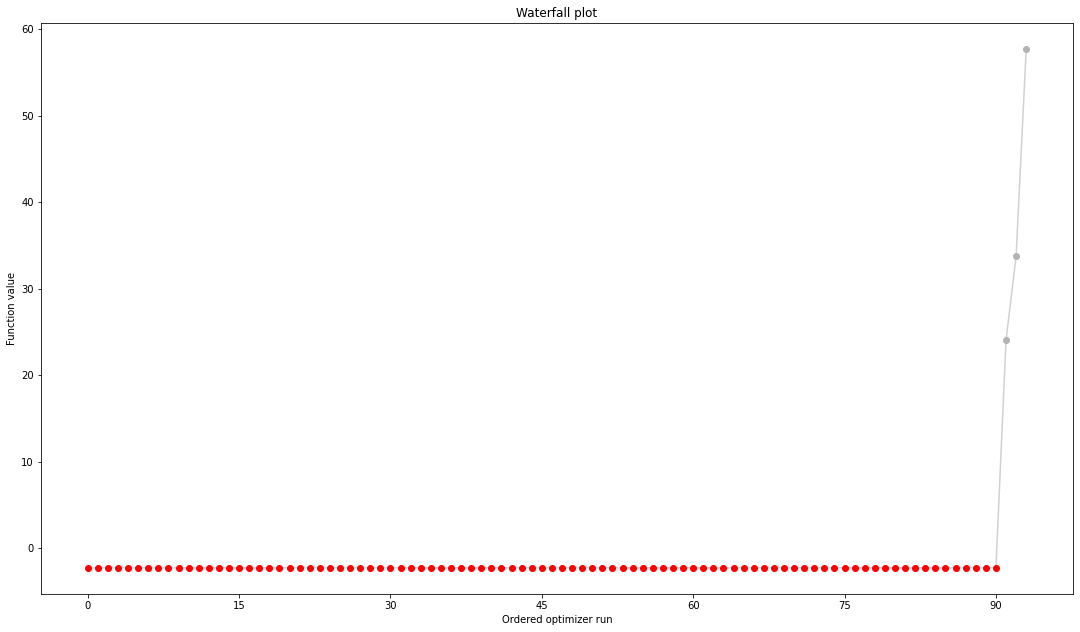

In [81]:
# waterfall plot
fvals = result.optimize_result.get_for_key("fval")
fval = np.array(fvals)
fval=fval[fval < 1e2]
visualize.waterfall_lowlevel(fval, scale_y='lin')

THis approach with specifying the prior using the parameter table is not realy feasible if we want to compute a regularization path for different values of the prior parameters, so for different regularization strengths. Because we would need a new parameter table every time. 
A better approach can be to get the normal objecitve function, which is the log-likelihood (negative?) and then add the regularization term, which was computed manually, by the `AggregatedObjective` function from pypesto.

Or another approach could be to create a prior dictionary using pypesto `get_parameter_prior_dict` and then `objective.NegLogParameterPriors`. --> This is the same I guess

In [124]:
def make_prior(model, strength, scale='lin'): 
  prior_list = []

  for i in range(len(model.getParameters())-1):
    priorType = 'laplace'
    priorParameters = [0, 1/strength]
    priorScale = scale
    prior = pypesto.objective.get_parameter_prior_dict(i, priorType, priorParameters, priorScale)
    prior_list.append(prior)

  return pypesto.objective.NegLogParameterPriors(prior_list)

In [152]:
model_name= "Spoegler_conversionReaction"
param_scale= 'lin'

# the yaml file includes all important links to other files
yaml_config ="petab/"+'lin2'+"/"+model_name+".yaml"
# create a petab problem
petab_problem2 = petab.Problem.from_yaml(yaml_config)

# or create from folder (did not work)
# petab_problem = petab.Problem.from_folder("petab/"+param_scale)

# import to amici
importer = pypesto.petab.PetabImporter(petab_problem)
#importer.compile_model()

model2 = importer.create_model()

2022-05-09 13:10:52.582 - amici.petab_import - INFO - Importing model ...
2022-05-09 13:10:52.585 - amici.petab_import - INFO - Model name is 'Sp_gler_ConversionReaction'.
Writing model code to '/home/vinc777/python_projects/moses/spoegler_model_reduction/l1_regularization/amici_models/Sp_gler_ConversionReaction'.
2022-05-09 13:10:52.586 - amici.petab_import - INFO - Species: 2
2022-05-09 13:10:52.587 - amici.petab_import - INFO - Global parameters: 3
2022-05-09 13:10:52.588 - amici.petab_import - INFO - Reactions: 0
2022-05-09 13:10:52.593 - amici.petab_import - INFO - Observables: 1
2022-05-09 13:10:52.595 - amici.petab_import - INFO - Sigmas: 1
2022-05-09 13:10:52.598 - amici.petab_import - DEBUG - Adding output parameters to model: OrderedDict([('noiseParameter1_observed_B', None)])
2022-05-09 13:10:52.599 - amici.petab_import - DEBUG - Adding initial assignments for []
2022-05-09 13:10:52.600 - amici.petab_import - DEBUG - Condition table: (1, 0)
2022-05-09 13:10:52.601 - amici.pe

running AmiciInstall
Adding OpenMP flags...
hdf5.h found in /usr/include/hdf5/serial
libhdf5.a found in /usr/lib/x86_64-linux-gnu/hdf5/serial
running build_ext
Changed extra_compile_args for unix to ['-fopenmp', '-std=c++14']
building 'Sp_gler_ConversionReaction._Sp_gler_ConversionReaction' extension
Testing SWIG executable swig4.0... SUCCEEDED.
swigging swig/Sp_gler_ConversionReaction.i to swig/Sp_gler_ConversionReaction_wrap.cpp
swig4.0 -python -c++ -modern -outdir Sp_gler_ConversionReaction -I/home/vinc777/.local/lib/python3.8/site-packages/amici/swig -I/home/vinc777/.local/lib/python3.8/site-packages/amici/include -o swig/Sp_gler_ConversionReaction_wrap.cpp swig/Sp_gler_ConversionReaction.i
Deprecated command line option: -modern. This option is now always on.
creating build
creating build/temp.linux-x86_64-3.8
creating build/temp.linux-x86_64-3.8/swig
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat 

In [126]:
# initialize solver and options
solver = importer.create_solver(model2)

# enable sensitivities
solver.setSensitivityOrder(amici.SensitivityOrder_first)       
solver.setSensitivityMethod(amici.SensitivityMethod_forward)  
model2.requireSensitivitiesForAllParameters()  

In [127]:
# objective function
obj2 = importer.create_objective()

neg_log_likelihood = obj2

Using existing amici model in folder /home/vinc777/python_projects/moses/spoegler_model_reduction/l1_regularization/amici_models/Sp_gler_ConversionReaction.


In [138]:
obj.x_names

['k1', 'k2', 'k3', 'sd_observed_B']

In [128]:
strength = 1

neg_log_prior = make_prior(model, strength)

neg_log_posterior = pypesto.objective.AggregatedObjective([neg_log_likelihood, neg_log_prior])

print('optimal x = ', petab_problem2.x_nominal)
print('optimal lh value', neg_log_posterior(petab_problem2.x_nominal))

optimal x =  [0.2, 0.1, 0.0, 0.15]
optimal lh value -1.0389690351046932


In [153]:
problem3 = importer.create_problem(neg_log_posterior)

In [156]:
problem3.objective([0.1]*3)

1995.026015307652

In [157]:
lb = np.array(petab_problem2.parameter_df['lowerBound'][0:3])
ub = np.array(petab_problem2.parameter_df['upperBound'][0:3])

# create optimizer object
optimizer = optimize.ScipyOptimizer()

# create problem object
problem2 = pypesto.Problem(objective=neg_log_posterior, lb=lb, ub=ub)

# do the optimization
n_starts = 100

result3 = optimize.minimize(problem=problem3, optimizer=optimizer, n_starts=n_starts, filename=None)

 43%|████▎     | 43/100 [04:20<03:52,  4.07s/it][Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 59.2548, mxstep steps taken before reaching tout. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 59.254778:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 59.2548, mxstep steps taken before reaching tout. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 59.254778:
AMICI failed to integrate the forward problem

 54%|█████▍    | 54/100 [05:25<05:16,  6.88s/it][Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 45.0345, mxstep steps taken before reaching tout. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 45.034543:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES

In [160]:
print('result', obj, '=', result3)
print('best result = ', result3.optimize_result.as_list('x')[0]['x'])

# print results
best_result3=result3.optimize_result.as_list("x")[0]["x"]
print('best parameter: ', best_result3)
print('best likelihood value: ', problem3.objective(best_result3[0:3]))

result <pypesto.objective.amici.AmiciObjective object at 0x7f257677f4f0> = <pypesto.result.result.Result object at 0x7f259ae137f0>
best result =  [0.25322131 0.07136649 0.00151638 0.15      ]
best parameter:  [0.25322131 0.07136649 0.00151638 0.15      ]
best likelihood value:  0.10960767962968099


In [135]:
print(problem2.x_free_indices)

[0, 1, 2, 3]


<AxesSubplot:title={'center':'Waterfall plot'}, xlabel='Ordered optimizer run', ylabel='Function value'>

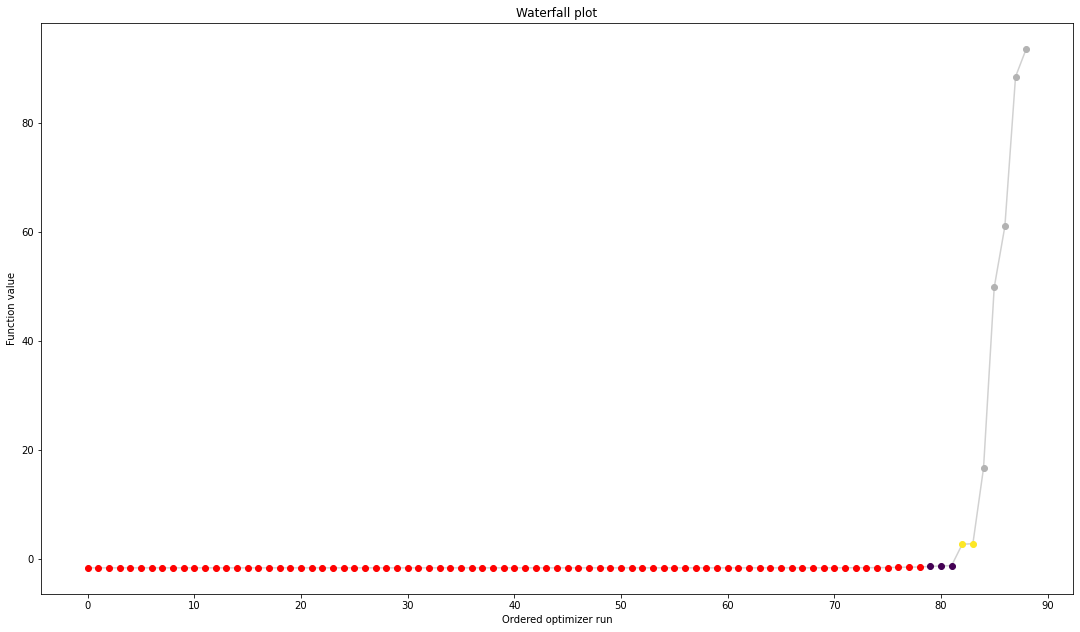

In [ ]:
# waterfall plot
fvals = result2.optimize_result.get_for_key("fval")
fval = np.array(fvals)
fval=fval[fval < 1e2]
visualize.waterfall_lowlevel(fval, scale_y='lin')

In [113]:
type(problem.objective)

pypesto.objective.aggregated.AggregatedObjective

In [111]:
type(neg_log_posterior)

pypesto.objective.aggregated.AggregatedObjective

In [114]:
o0 = problem.objective
o1 = neg_log_posterior


In [115]:
dir(o0)

['__abstractmethods__',
 '__call__',
 '__class__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_objectives',
 '_x_names',
 'call_unprocessed',
 'check_grad',
 'check_grad_multi_eps',
 'check_gradients_match_finite_differences',
 'check_mode',
 'check_sensi_orders',
 'get_config',
 'get_fval',
 'get_grad',
 'get_hess',
 'get_res',
 'get_sres',
 'has_fun',
 'has_grad',
 'has_hess',
 'has_hessp',
 'has_res',
 'has_sres',
 'history',
 'initialize',
 'output_to_tuple',
 'pre_post_processor',
 'update_from_problem',
 'x_names']

In [117]:
p0 = o0._objectives[1]

In [118]:
p1 = o1._objectives[1]

In [121]:
dir(p0)

['__abstractmethods__',
 '__call__',
 '__class__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_x_names',
 'call_unprocessed',
 'check_grad',
 'check_grad_multi_eps',
 'check_gradients_match_finite_differences',
 'check_mode',
 'check_sensi_orders',
 'get_config',
 'get_fval',
 'get_grad',
 'get_hess',
 'get_res',
 'get_sres',
 'gradient_neg_log_density',
 'has_fun',
 'has_grad',
 'has_hess',
 'has_hessp',
 'has_res',
 'has_sres',
 'hessian_neg_log_density',
 'hessian_vp_neg_log_density',
 'history',
 'initialize',
 'neg_log_density',
 'output_to_tuple',
 'pre_post_processor',
 'prior_list',
 'residual',
 'residual_jacobian',
 'updat

In [122]:
p0.prior_list

[{'index': 0,
  'density_fun': <function pypesto.objective.priors._prior_densities.<locals>.log_f(x)>,
  'density_dx': <function pypesto.objective.priors._prior_densities.<locals>.d_log_f_dx(x)>,
  'density_ddx': <function pypesto.objective.priors._get_constant_function.<locals>.function(x)>,
  'residual': <function pypesto.objective.priors._prior_densities.<locals>.res(x)>,
  'residual_dx': <function pypesto.objective.priors._prior_densities.<locals>.d_res_dx(x)>},
 {'index': 1,
  'density_fun': <function pypesto.objective.priors._prior_densities.<locals>.log_f(x)>,
  'density_dx': <function pypesto.objective.priors._prior_densities.<locals>.d_log_f_dx(x)>,
  'density_ddx': <function pypesto.objective.priors._get_constant_function.<locals>.function(x)>,
  'residual': <function pypesto.objective.priors._prior_densities.<locals>.res(x)>,
  'residual_dx': <function pypesto.objective.priors._prior_densities.<locals>.d_res_dx(x)>},
 {'index': 2,
  'density_fun': <function pypesto.objective

In [123]:
p1.prior_list

[{'index': 0,
  'density_fun': <function pypesto.objective.priors._prior_densities.<locals>.log_f(x)>,
  'density_dx': <function pypesto.objective.priors._prior_densities.<locals>.d_log_f_dx(x)>,
  'density_ddx': <function pypesto.objective.priors._get_constant_function.<locals>.function(x)>,
  'residual': <function pypesto.objective.priors._prior_densities.<locals>.res(x)>,
  'residual_dx': <function pypesto.objective.priors._prior_densities.<locals>.d_res_dx(x)>},
 {'index': 1,
  'density_fun': <function pypesto.objective.priors._prior_densities.<locals>.log_f(x)>,
  'density_dx': <function pypesto.objective.priors._prior_densities.<locals>.d_log_f_dx(x)>,
  'density_ddx': <function pypesto.objective.priors._get_constant_function.<locals>.function(x)>,
  'residual': <function pypesto.objective.priors._prior_densities.<locals>.res(x)>,
  'residual_dx': <function pypesto.objective.priors._prior_densities.<locals>.d_res_dx(x)>},
 {'index': 2,
  'density_fun': <function pypesto.objective